## Passo 1 Carregaremos uma base simples com duas dimensões.

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
from scipy.io import loadmat

data = loadmat('MLs15a anomalia.mat')
X = data['X']
X.shape

(307, 2)

##Passo 2 Temo um cluster bem apertado no centro com vários valores mais distantes do cluster. Neste exemplo os exemplos distantes podem ser consideradas anomalias.

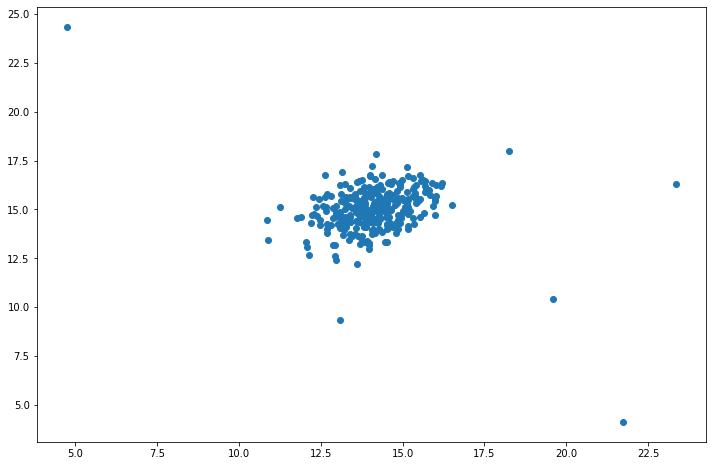

In [ ]:
fig, ax = plt.subplots(figsize=(12,8))
ax.scatter(X[:,0], X[:,1])

## Passo 3 Para descobrir, vamos estimar uma distribuição gaussiana para cada característica nos dados. Criaremos uma função que retorna a média e a variância de cada recurso.

In [ ]:
def estimate_gaussian(X):
    mu = X.mean(axis=0)
    sigma = X.var(axis=0)
    
    return mu, sigma
    
mu, sigma = estimate_gaussian(X)
mu, sigma

(array([14.11222578, 14.99771051]), array([1.83263141, 1.70974533]))

## Passo 4 Agora que temos os parâmetros do nosso modelo, precisamos determinar um limite de probabilidade que indica que um exemplo deve ser considerado uma anomalia. 
Para fazer isso, precisamos usar um conjunto de dados de validação rotulados (onde as anomalias verdadeiras foram marcadas como tal) e testar o desempenho do modelo na identificação dessas anomalias com valores de limite diferentes. 

In [ ]:
Xval = data['Xval']
yval = data['yval']

Xval.shape, yval.shape

((307, 2), (307, 1))

Também precisamos de uma maneira de calcular a probabilidade de um ponto de dados pertencer a uma distribuição normal. Felizmente o SciPy tem isso pronto.

In [ ]:
from scipy import stats
dist = stats.norm(mu[0], sigma[0])
dist.pdf(15)

0.1935875044615038

Também podemos passar uma matriz para a função de densidade de probabilidade e obter a densidade de probabilidade em todos os pontos do conjunto de dados.

In [ ]:
dist.pdf(X[:,0])[0:50]

array([0.183842  , 0.20221694, 0.21746136, 0.19778763, 0.20858956,
       0.21652359, 0.16991291, 0.15123542, 0.1163989 , 0.1594734 ,
       0.21716057, 0.21760472, 0.20141857, 0.20157497, 0.21711385,
       0.21758775, 0.21695576, 0.2138258 , 0.21057069, 0.1173018 ,
       0.20765108, 0.21717452, 0.19510663, 0.21702152, 0.17429399,
       0.15413455, 0.21000109, 0.20223586, 0.21031898, 0.21313426,
       0.16158946, 0.2170794 , 0.17825767, 0.17414633, 0.1264951 ,
       0.19723662, 0.14538809, 0.21766361, 0.21191386, 0.21729442,
       0.21238912, 0.18799417, 0.21259798, 0.21752767, 0.20616968,
       0.21520366, 0.1280081 , 0.21768113, 0.21539967, 0.16913173])

Vamos calcular e salvar a densidade de probabilidade de cada um dos valores em nosso conjunto de dados, considerando os parâmetros do modelo gaussiano que calculamos acima.

In [ ]:
p = np.zeros((X.shape[0], X.shape[1]))
p[:,0] = stats.norm(mu[0], sigma[0]).pdf(X[:,0])
p[:,1] = stats.norm(mu[1], sigma[1]).pdf(X[:,1])

p.shape

(307, 2)

##Passo 5 Preparando validação
Precisamos fazer isso para o conjunto de validação (usando os mesmos parâmetros do modelo). Usaremos essas probabilidades combinadas com o rótulo verdadeiro para determinar o limite de probabilidade ideal para atribuir pontos de dados como anomalias.

In [ ]:
pval = np.zeros((Xval.shape[0], Xval.shape[1]))
pval[:,0] = stats.norm(mu[0], sigma[0]).pdf(Xval[:,0])
pval[:,1] = stats.norm(mu[1], sigma[1]).pdf(Xval[:,1])

pval.shape

(307, 2)

Em seguida, precisamos de uma função que encontre o melhor valor limite, dados os valores de densidade de probabilidade e os rótulos verdadeiros. Para fazer isso, calcularemos a pontuação F1 para valores variados de epsilon. F1 é uma função do número de verdadeiros positivos, falsos positivos e falsos negativos. As equações estão no texto do exercício.

In [ ]:
def select_threshold(pval, yval):
    best_epsilon = 0
    best_f1 = 0
    f1 = 0
    
    step = (pval.max() - pval.min()) / 1000
    
    for epsilon in np.arange(pval.min(), pval.max(), step):
        preds = pval < epsilon
        
        tp = np.sum(np.logical_and(preds == 1, yval == 1)).astype(float)
        fp = np.sum(np.logical_and(preds == 1, yval == 0)).astype(float)
        fn = np.sum(np.logical_and(preds == 0, yval == 1)).astype(float)
        
        precision = tp / (tp + fp)
        recall = tp / (tp + fn)
        f1 = (2 * precision * recall) / (precision + recall)
        
        if f1 > best_f1:
            best_f1 = f1
            best_epsilon = epsilon
    
    return best_epsilon, best_f1

epsilon, f1 = select_threshold(pval, yval)
epsilon, f1

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app


(0.009566706005956842, 0.7142857142857143)

## Passo 6 Aplicar o limite ao conjunto de dados e visualizar os resultados.

In [ ]:
# índices dos valores considerados outliers
outliers = np.where(p < epsilon)
outliers

(array([300, 301, 301, 303, 303, 304, 306, 306]),
 array([1, 0, 1, 0, 1, 0, 0, 1]))

Os pontos em vermelho são os que foram sinalizados como outliers. Estes parecem bastante razoáveis. O ponto superior direito que tem alguma separação, mas não foi sinalizado, talvez poderia ser um valor atípico também, mas é bastante próximo.

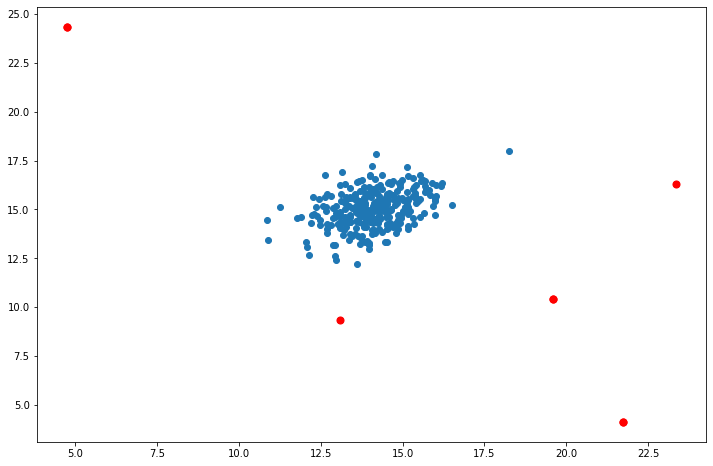

In [ ]:
fig, ax = plt.subplots(figsize=(12,8))
ax.scatter(X[:,0], X[:,1])
ax.scatter(X[outliers[0],0], X[outliers[0],1], s=50, color='r', marker='o')